In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import sklearn as sk
import seaborn as sns
from tqdm import tqdm

## preprocessing

In [2]:
raw_data = scp.io.arff.loadarff('data/EEG Eye State.arff')
df = pd.DataFrame(raw_data[0])
df['eyeDetection'] = df['eyeDetection'].apply(lambda x: int(x.decode()))

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, stratify=y, test_size=0.2)

scaler = sk.preprocessing.StandardScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)

Check for y distribution. Balanced due to stratification

In [3]:
unique_train, train_counts = np.unique(y_train, return_counts=True)
unique_test, test_counts = np.unique(y_test, return_counts=True)
print(f'Train label distribution: {dict(zip(unique_train, train_counts))}')
print(f'Test label distribution: {dict(zip(unique_test, test_counts))}')

Train label distribution: {0: 6606, 1: 5378}
Test label distribution: {0: 1651, 1: 1345}


## initial visualisation

## PCA

In [4]:
init_pca = sk.decomposition.PCA(n_components=14)
init_pca_fit = init_pca.fit(X_train_scaled)

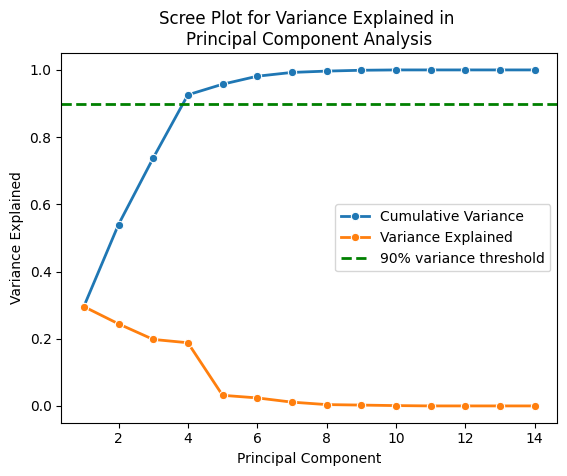

In [5]:
init_PC_values = np.arange(init_pca.n_components_) + 1
init_variance = np.cumsum(init_pca.explained_variance_ratio_)

sns.lineplot(x=init_PC_values, y=init_variance, label='Cumulative Variance', marker='o', linewidth=2)
sns.lineplot(x=init_PC_values, y=init_pca.explained_variance_ratio_, label='Variance Explained', marker='o', linewidth=2)
plt.axhline(y=0.9, color='green', linestyle='--', linewidth=2, label='90% variance threshold')

plt.title('Scree Plot for Variance Explained in \nPrincipal Component Analysis')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend()
plt.savefig('scree_plot_pca.png')
plt.show()

The drop in the scree plot is at PC4. the first 4 components account for 91.5% of the total variance. Therefore, I will only use the first four to look for clusters/patterns.

In [6]:
pca = sk.decomposition.PCA(n_components=4)
X_pca = pca.fit(X_train_scaled)

X_pca_train = pca.transform(X_train_scaled)
X_pca_test = pca.transform(X_test_scaled)

### Sample PCA plot (PC1 vs PC2)

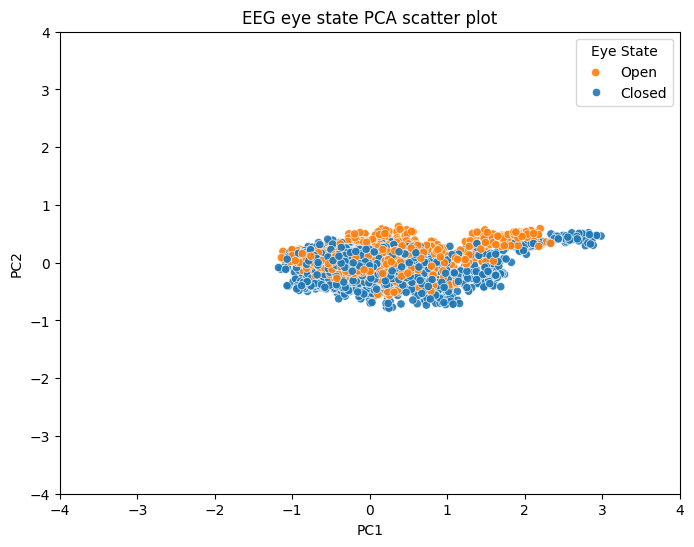

In [7]:
pca_df = pd.DataFrame(X_pca_train, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df['eyeDetection'] = y_train

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='eyeDetection',
    alpha=0.9
)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('EEG eye state PCA scatter plot')
plt.legend(title='Eye State', labels=['Open', 'Closed'])
plt.savefig('pca_example.png')
plt.show()

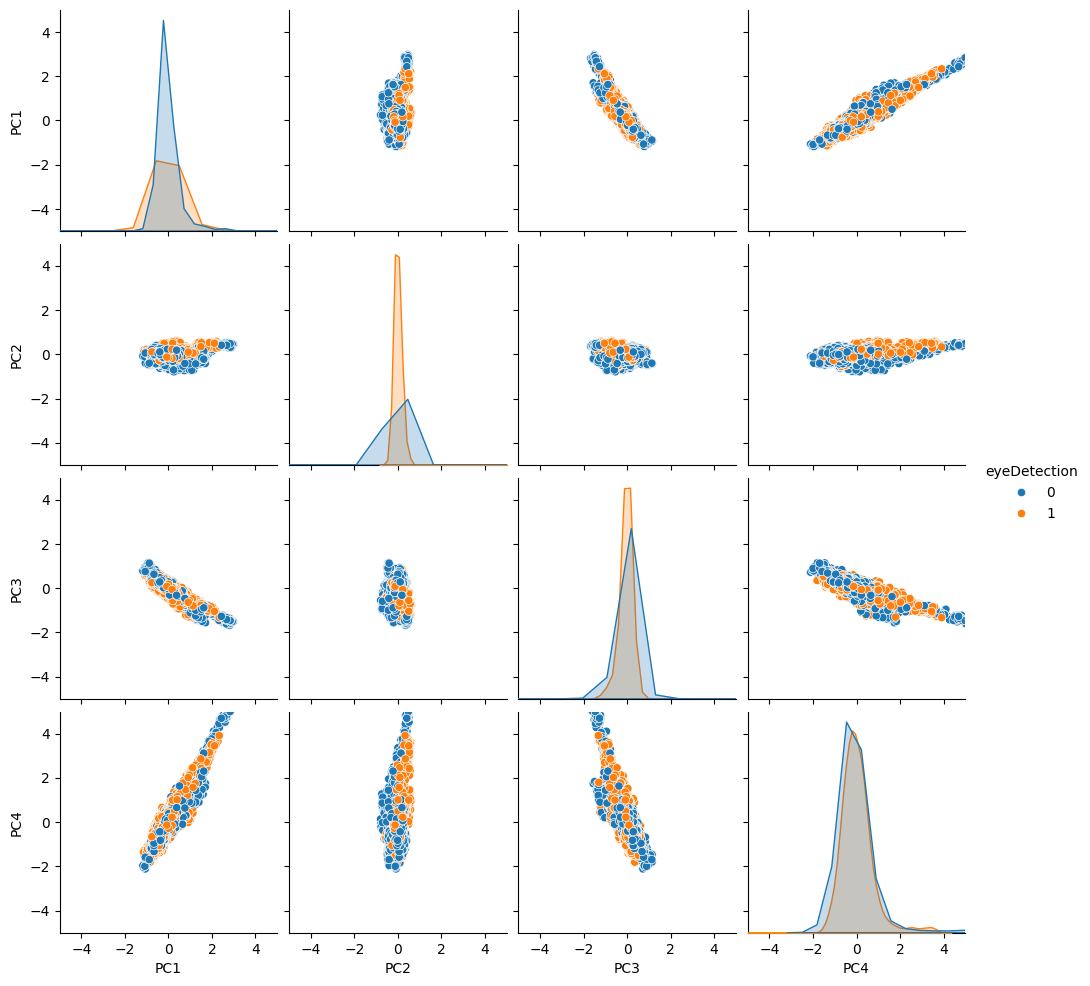

In [10]:
g = sns.pairplot(data=pca_df, hue='eyeDetection')

for ax in g.axes.flatten():
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
plt.savefig('pairplot_pca.png')
plt.show()

### Hyperparameter tuning for k-nearest neighbours

- number of neighbours = [1, 2,..., 40]
- weights = [uniform, distance]

I chose metrics according to this article https://www.kdnuggets.com/2020/11/most-popular-distance-metrics-knn.html

- metric = [eucliean, manhattan]

I then use the sklearn GridSearchCV method to see which combination is the best for this problem. This method requires:
- An estimator: kNN
- A parameter grid
- Scoring: accuracy
- cv: 5
- verbose: 1

Outputs printed will be:
- best_params to see which parameters performed the best
- best_index to return the index of the best combination

At this point I noticed that I was getting suspiciously low test accuracy ($\approx$ 39%). The y_test array turned out to be extremely unbalanced, so I went back and changed it to stratify y.

In [ ]:
knn_parameters = {
    'n_neighbors' : [i for i in range(1, 41)],
    'weights' : ['uniform', 'distance'],
    'metric' : ['euclidean', 'manhattan']
}

knn = sk.neighbors.KNeighborsClassifier()

knn_param_search = sk.model_selection.GridSearchCV(estimator=knn,
                                                   param_grid=knn_parameters,
                                                   cv=5,
                                                   scoring='accuracy',
                                                   verbose=1)
knn_param_search.fit(X_pca_train, y_train)
print(f'kNN best parameters: {knn_param_search.best_params_}')
print(f'kNN index of best parameters: {knn_param_search.best_index_}')

knn_best = knn_param_search.best_estimator_
knn_test_pred = knn_best.predict(X_pca_test)
print(f'kNN test accuracy on best parameters: {sk.metrics.balanced_accuracy_score(y_test, knn_test_pred):.3f}')

In [ ]:
cm = sk.metrics.confusion_matrix(y_test, knn_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='crest')
plt.title('Confusion Matrix for kNN\nwith PCA data')
plt.xlabel('Model Predictions')
plt.ylabel('True Labels')
plt.savefig('cm_knn_pca.png')
plt.show()

x### Hyperparameter tuning for SVM



- regularisation parameter C = [0.1, 1, 10, 20]
- kernel = rbf, as the data isn't linearly separable
- gamma for rbf = [scale, 0.001, 0.01, 0.1]

Again, using GridSearchCV with the same parameters as above.

In [ ]:
svm = sk.svm.SVC()

svm_params = {
    'C' : [0.1, 1, 10, 20],
    'gamma' : ['scale', 0.001, 0.01, 0.1]
}

svm_param_search = sk.model_selection.GridSearchCV(svm,
                                                   param_grid=svm_params,
                                                   scoring='accuracy',
                                                   verbose=1)

svm_param_search.fit(X_pca_train, y_train)
print(f'SVM best parameters: {svm_param_search.best_params_}')
print(f'SVM index of best parameters: {svm_param_search.best_index_}')

svm_best = svm_param_search.best_estimator_
svm_test_pred = svm_best.predict(X_pca_test)
print(f'SVM test accuracy on best parameters: {sk.metrics.balanced_accuracy_score(y_test, svm_test_pred):.3f}')

In [ ]:
cm = sk.metrics.confusion_matrix(y_test, svm_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='crest')
plt.title('Confusion Matrix for SVM\nwith PCA data')
plt.xlabel('Model Predictions')
plt.ylabel('True Labels')
plt.savefig('cm_svm_pca.png')
plt.show()

### Hyperparameter Tuning for Random Forest Classifier

- estimators = [100, 200, 300, 400, 500]
- max depth = [None, 10, 20]

In [ ]:
rf = sk.ensemble.RandomForestClassifier(random_state=4)

rf_params = {
    'n_estimators' : [i for i in range(100, 501, 100)],
    'max_depth' : [None, 10, 20]
}

rf_param_search = sk.model_selection.GridSearchCV(rf,
                                                   param_grid=rf_params,
                                                   scoring='accuracy',
                                                   verbose=1)

rf_param_search.fit(X_pca_train, y_train)
print(f'Random Forest best parameters: {rf_param_search.best_params_}')
print(f'Random Forest index of best parameters: {rf_param_search.best_index_}')

rf_best = rf_param_search.best_estimator_
rf_test_pred = rf_best.predict(X_pca_test)
print(f'Random Forest test accuracy on best parameters: {sk.metrics.balanced_accuracy_score(y_test, rf_test_pred):.3f}')

In [ ]:
cm = sk.metrics.confusion_matrix(y_test, rf_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='crest')
plt.title('Confusion Matrix for Random Forest Classifier\nwith PCA data')
plt.xlabel('Model Predictions')
plt.ylabel('True Labels')
plt.savefig('cm_rf_pca.png')
plt.show()

Decided to research smoothing techniques. Found moving average: choose a fixed window (increment by some step) and calculate the average over it, then train on that.

Requires reinstantiated X and y arrays, as it can't be shuffled for time series smoothing.

In [ ]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.3, shuffle=False)
scaler = sk.preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

define a moving average function to smooth the data

In [ ]:
def moving_window(X, y, window_size=70, step=43, mean_mode=True):
    i = 0
    X_w, y_w = [], []
    mid = window_size // 2

    while (i+window_size) <= X.shape[0]:
        w = X[i:i+window_size, :]
        if mean_mode:
            means = w.mean(axis=0)
            X_w.append(means)
        else:
            median = np.median(w, axis=0)
            X_w.append(median)
        label = int(y[i+mid])
        y_w.append(label)
        i += step
    return np.vstack(X_w), np.vstack(y_w).ravel()

### kNN with smoothing

In [ ]:
window_sizes = [i for i in range(10, 160, 2)]
k_vals = [i for i in range(2, 40, 2)]

results = np.zeros((len(window_sizes), len(k_vals)))

for a, w in tqdm(enumerate(window_sizes), total=len(window_sizes)):
    X_train_smoothed, y_train_smoothed = moving_window(X=X_train_scaled, y=y_train, window_size=w, step=int(w/2))
    X_test_smoothed, y_test_smoothed = moving_window(X=X_test_scaled, y=y_test, window_size=w, step=int(w/2))

    for c, k in enumerate(k_vals):
        knn = sk.neighbors.KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
        knn.fit(X_train_smoothed, y_train_smoothed)
        prediction = knn.predict(X_test_smoothed)
        acc = sk.metrics.balanced_accuracy_score(y_test_smoothed, prediction)
        results[a, c] = acc

best_index = np.unravel_index(np.argmax(results), results.shape)
best_window = window_sizes[best_index[0]]
best_step = int(best_window/2)
best_k = k_vals[best_index[1]]
best_score = results[best_index]

print(f'Best kNN test accuracy: {best_score:.3f}')
print(f'best kNN parameters: window_size={best_window}, step={best_step}, k={best_k}')

### SVM with smoothing

In [ ]:
window_sizes = [i for i in range(20, 160, 2)]
C_vals = [0.1, 1, 10, 20]
gammas = ['scale', 0.001, 0.01, 0.1]

results = np.zeros((len(window_sizes), len(C_vals), len(gammas)))

for a, w in tqdm(enumerate(window_sizes), total=len(window_sizes)):
    X_train_smoothed, y_train_smoothed = moving_window(X=X_train_scaled, y=y_train, window_size=w, step=int(w/2))
    X_test_smoothed, y_test_smoothed = moving_window(X=X_test_scaled, y=y_test, window_size=w, step=int(w/2))

    for b, C_val in enumerate(C_vals):
        for c, g in enumerate(gammas):
            svm = sk.svm.SVC(kernel='rbf', C=C_val, gamma=g)
            svm.fit(X_train_smoothed, y_train_smoothed)
            prediction = svm.predict(X_test_smoothed)
            acc = sk.metrics.balanced_accuracy_score(y_test_smoothed, prediction)
            results[a, b, c] = acc

best_index = np.unravel_index(np.argmax(results), results.shape)
best_window = window_sizes[best_index[0]]
best_step = int(best_window/2)
best_C = C_vals[best_index[1]]
best_gamma = gammas[best_index[2]]
best_score = results[best_index]

print(f'Best SVM test accuracy: {best_score:.3f}')
print(f'best SVM parameters: window_size={best_window}, step={best_step}, best C={best_C}, best gamma={best_gamma}')

### Random Forest with smoothing

In [ ]:
window_sizes = [i for i in range(20, 160, 2)]
n_estimators = [i for i in range(100, 501, 100)]
max_depth = [None, 10, 20]

results = np.zeros((len(window_sizes), len(n_estimators), len(max_depth)))

for a, w in tqdm(enumerate(window_sizes), total=len(window_sizes)):
    X_train_smoothed, y_train_smoothed = moving_window(X=X_train_scaled, y=y_train, window_size=w, step=int(w/2))
    X_test_smoothed, y_test_smoothed = moving_window(X=X_test_scaled, y=y_test, window_size=w, step=int(w/2))

    for b, est in enumerate(n_estimators):
        for c, depth in enumerate(max_depth):
            rf = sk.ensemble.RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=8)
            rf.fit(X_train_smoothed, y_train_smoothed)
            prediction = rf.predict(X_test_smoothed)
            acc = sk.metrics.balanced_accuracy_score(y_test_smoothed, prediction)
            results[a, b, c] = acc

best_index = np.unravel_index(np.argmax(results), results.shape)
best_window = window_sizes[best_index[0]]
best_step = int(best_window/2)
best_n = n_estimators[best_index[1]]
best_depth = max_depth[best_index[2]]

best_score = results[best_index]

print(f'Best Random Forest test accuracy: {best_score:.3f}')
print(f'Best Random Forest parameters: window_size={best_window}, step={best_step}, best n_estimators={best_n}, best max depth={best_depth}')

## Analytics for best model: Random Forest Classifier

In [ ]:
X_train_smoothed, y_train_smoothed = moving_window(X=X_train_scaled, y=y_train, window_size=156, step=78)
X_test_smoothed, y_test_smoothed = moving_window(X=X_test_scaled, y=y_test, window_size=156, step=78)
rf = sk.ensemble.RandomForestClassifier(n_estimators=100, max_depth=None, random_state=8)
rf.fit(X_train_smoothed, y_train_smoothed)
prediction = rf.predict(X_test_smoothed)
cm = sk.metrics.confusion_matrix(y_test_smoothed, prediction)
sns.heatmap(cm, annot=True, fmt='d', cmap='crest')
plt.title('Confusion Matrix for Random Forest Classifier\nwith Data Smoothing')
plt.xlabel('Model Predictions')
plt.ylabel('True Labels')
plt.savefig('cm_rf_smooth.png')
plt.show()
acc = sk.metrics.balanced_accuracy_score(y_test_smoothed, prediction)
print(f'Balanced accuracy: {acc:.3f}')